In [19]:
# Installation des pycoSHARKs
import sys
# !{sys.executable} -m pip install pycoshark
# !{sys.executable} -m pip install scikit-learn


In [20]:
# Data Manipulation
from mongoengine import connect, disconnect
from pycoshark.mongomodels import File, FileAction, Commit, Project, VCSSystem, IssueSystem,Hunk, Refactoring, IssueSystem, Issue, IssueComment, MailingList, Message
from pycoshark.utils import create_mongodb_uri_string
import pandas as pd
import numpy as np
import scipy.stats as stats


# DataViz
import pandas_profiling as pp
import seaborn as sns
import matplotlib.pyplot as plt

# Modeling
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn import metrics

from sklearn.metrics import mean_squared_error 
from math import sqrt

# Database credentials
user = 'grundlagenki2021'
password = '38BTGx71d'
host = '134.76.81.151'
port = '27017'
authentication_db = 'smartshark'
database = "smartshark"
ssl_enabled = None

# Establish connection
uri = create_mongodb_uri_string(user, password, host, port, authentication_db, ssl_enabled)
connect(database, host=uri)

pd.options.display.max_rows = 10000
pd.options.display.max_columns = 100
pd.options.display.float_format = '{:.2f}'.format

In [21]:
def getreport(projectnames):
    projectdf = []
    for items in (projectnames):
        
    # We first need the the project from the database
        project = Project.objects(name=items).get()
        issue_tracker = IssueSystem.objects(project_id=project.id).get()
        dfin = pd.read_json(Issue.objects(issue_system_id=issue_tracker.id).to_json())
        extid = issue_tracker.url.rsplit('=', 1)[1] # obtain the correct external_id for each repository to sort out invalid issues or logs
        dfin = dfin[dfin.external_id.str.startswith(extid)]#print(projectdf)
        #print('read '+str(items))
        projectdf.append(dfin)
        #print(len(projectdf))
    #print(projectdf[0])    
    df1 = pd.concat(projectdf)   
    print(df1.shape)    
    df = df1
    
    df['created_at'] = pd.json_normalize(df['created_at'])
    df['updated_at'] = pd.json_normalize(df['updated_at'])
    df['timetofix'] = (df.updated_at-df.created_at)/(100*60*60*24*30.41)
    df['status'] = df['status'].replace('Closed', 1)
    df['status'] = df['status'].replace('In Progress', 0)
    df['status'] = df['status'].replace('Open', 0)
    df['status'] = df['status'].replace('Resolved', 1)
    df['status'] = df['status'].replace('Reopened', 0)
    df['status'] = df['status'].replace('Patch Available', 0)

    q_low = df['timetofix'].quantile(0.10)
    q_high = df['timetofix'].quantile(0.90)

    print(q_high)
    print(q_low)

    df = df[(df['timetofix'] < q_high) | (df['timetofix'] > q_low)]

    df = df[[ 'creator_id', 'issue_type', 'priority', 'status', 'created_at', 'updated_at', 'timetofix']]
    df = df.dropna()
    df = pd.get_dummies(data=df, columns=['priority', 'issue_type'])

    return(df)

projects = ['calcite',]
df = getreport(projects)

(2389, 24)
111.47047552507705
4.705140852789653e-05


In [22]:
#df
#sns.pairplot(df, y_vars=['status'])
#df.head()
#df.corr().style.background_gradient(cmap='coolwarm')

In [23]:
# Entfernen von Außreisern
#time_25 = df.describe().T.loc['timetofix', '25%']
#time_75 = df.describe().T.loc['timetofix', '75%']

#IQR_time = 1.5 * (time_75 - time_25)

#df = df.query(' timetofix >= (@time_25 - @IQR_time) & timetofix <= (@time_75 + @IQR_time) ')
# Zu berücksichtigende Merkmale und gesuchte Daten wählen
y_class=df.timetofix
x_class=df.drop(columns=['creator_id','timetofix',])

# In Training- und Testdaten aufteilen
X_train, X_test, y_train, y_test = train_test_split(x_class, y_class, test_size=0.3) # 70% training and 30% test

In [24]:
old_acc = -10
opt_k = 1
for k in range(50):
    k = k+1
    knn = KNeighborsRegressor(n_neighbors = k)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test) 
    if old_acc < knn.score(X_test, y_test):
        old_acc = knn.score(X_test, y_test)
        opt_k = k
    #print(k,knn.score(X_test, y_test))
print(opt_k)

3


In [25]:
knn = KNeighborsRegressor(n_neighbors = opt_k)
knn.fit(X_train, y_train)

y_pred = knn.predict(X_test) 

print("Accuracy:",knn.score(X_test, y_test))

performance = pd.DataFrame({ 'True Value': y_test, 'Prediction': y_pred, 'Error': y_test - y_pred})
performance

Accuracy: 0.9972713108470415


,True Value,Prediction,Error
2220,0.82,0.13,0.69
777,0.00,0.00,0.00
1567,6.26,5.04,1.22
430,0.00,0.00,-0.00
2026,201.03,191.36,9.67
1839,12.83,13.19,-0.36
274,17.78,17.39,0.38
1364,14.57,14.99,-0.42
2260,35.85,41.01,-5.15
1915,8.18,8.17,0.01


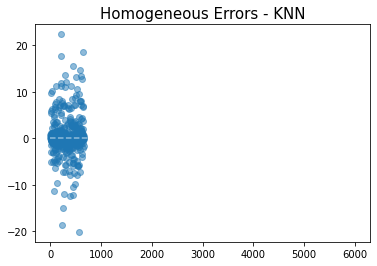

In [26]:
plt.figure()
# Errors
ax_x= performance['True Value']
ax_y= performance['Prediction']
yerr= performance['Error']

plt.scatter(range(len(yerr)), yerr, alpha=.5)
plt.title('Homogeneous Errors - KNN', size=15)
plt.hlines(y=0, xmin=0, xmax=6000, linestyle='--', color='white', alpha=.5)

((array([-3.07444806, -2.79945332, -2.64531992, -2.53627656, -2.45099303,
         -2.38050938, -2.32017947, -2.26727191, -2.22003974, -2.17729559,
         -2.13819439, -2.10211253, -2.06857624, -2.03721682, -2.00774149,
         -1.97991377, -1.95353978, -1.92845853, -1.90453481, -1.88165394,
         -1.85971776, -1.83864161, -1.81835189, -1.79878424, -1.77988205,
         -1.76159519, -1.74387914, -1.7266941 , -1.71000437, -1.69377779,
         -1.67798532, -1.66260058, -1.64759959, -1.63296045, -1.61866313,
         -1.60468923, -1.59102183, -1.57764532, -1.5645453 , -1.55170839,
         -1.53912221, -1.52677523, -1.51465671, -1.50275663, -1.49106564,
         -1.47957496, -1.46827639, -1.4571622 , -1.44622515, -1.43545841,
         -1.42485555, -1.41441049, -1.40411751, -1.39397117, -1.38396634,
         -1.37409816, -1.36436201, -1.35475349, -1.34526845, -1.33590291,
         -1.32665311, -1.31751544, -1.30848648, -1.29956294, -1.29074171,
         -1.28201978, -1.2733943 , -1.

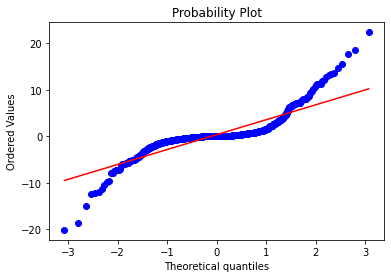

In [27]:
from scipy.stats import probplot
#QQ Plot
probplot(yerr, dist='norm', plot=plt)